In [148]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import xgboost as xgb

from scipy import stats

import shap 
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error

In [149]:
housing_df = pd.read_csv("/Users/codexplore/Developer/repos/machine-learning-101/data/common_datasets/housing.csv")


## Feature Engineering

In [150]:
housing_df.loc[:,"rooms_per_house"] = housing_df["total_rooms"] / housing_df["households"]
housing_df.loc[:,"bedrooms_ratio"] = housing_df["total_bedrooms"] / housing_df["total_rooms"]
housing_df.loc[:,"people_per_house"] = housing_df["population"] / housing_df["households"]


In [151]:
housing_df = housing_df[~(housing_df["median_house_value"] > 500_000)]

In [152]:
housing_df.loc[:, "income_cat"] = pd.cut(housing_df["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
X = housing_df.drop("median_house_value", axis=1)
y = housing_df["median_house_value"]

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=X["income_cat"], test_size=0.2, random_state=42)

In [154]:
X_train = X_train.drop(["income_cat"], axis=1)
X_test = X_test.drop(["income_cat"],axis=1)

In [155]:
def detect_column_type(df, target_col=None):
    if target_col:
        df = df.drop(target_col, axis=1)
    # Select numeric columns only
    numerical_cols = [cname for cname in df.select_dtypes(include=np.number).columns]
    # print(f"Numerical Features  : {numerical_cols}")
    # Categorical columns in the training data
    categorical_cols = [col for col in df.select_dtypes(exclude=np.number).columns]
    return numerical_cols, categorical_cols

def preprocess_data(X):
    # Convert categorical columns to 'category' dtype as required by lgb.Dataset
    _, categorical_cols = detect_column_type(X_train)
    for col in categorical_cols:
        X[col] = X[col].astype("category")
    return X

X_train = preprocess_data(X_train)
X_test = preprocess_data(X_test)


In [156]:
X_train.shape, X_test.shape

((15740, 12), (3935, 12))

## Model Training

### Baseline Model

In [ ]:
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train, enable_categorical=True) 
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test, enable_categorical=True) 



In [193]:
# Define hyperparameters
params = {"objective": "reg:squarederror", 
          "tree_method": "hist" # gpu_hist to enable GPU 
}
num_boost_round = 5000
# Uses xgb.train instead of XGBRegressor, making it compatible with DMatrix.
xgb_r = xgb.train(params = params, 
                  dtrain = train_dmatrix,
                  num_boost_round = num_boost_round # for number of boosting rounds. Internally, XGBoost minimizes the loss function RMSE in small incremental rounds 
) 

# ===== 4. Make Predictions (Exponentiate back) =====
y_pred = xgb_r.predict(test_dmatrix)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"RMSE of the base model: {rmse:.3f}")

RMSE of the base model: 41927.761


### Using Validation Sets During Training

- `evals` create a list of two tuples that each contain two elements. The first element is the array for the model to evaluate, and the second is the array’s name.
- `early_stopping` forces XGBoost to watch the validation loss, and if it stops improving for a specified number of rounds, it automatically stops training.

In [159]:
# evaluation on both train & test set
evals = [(train_dmatrix, "train"), (test_dmatrix, "validation")]

model = xgb.train(
   params=params,
   dtrain=train_dmatrix,
   num_boost_round=num_boost_round,
   evals=evals,
   verbose_eval=50, # print evaluation metrics every 50 rounds
   early_stopping_rounds=50 # automatically stop the training if validation loss doesn't improve for 50 consecutive rounds.
)

[0]	train-rmse:156914.52284	validation-rmse:155364.49225
[50]	train-rmse:30816.29389	validation-rmse:42134.59480
[100]	train-rmse:24176.59295	validation-rmse:41481.62299
[150]	train-rmse:19715.85129	validation-rmse:41416.29269
[195]	train-rmse:16953.19578	validation-rmse:41407.63596


### Cross-Validation
- `results` has the same number of rows as the number of boosting rounds. 
- Each row is the average of all splits for that round. So, to find the best score, we take the minimum of the `test-rmse-mean` column:

In [160]:
results = xgb.cv(
   params, train_dmatrix,
   num_boost_round=num_boost_round,
   metrics=["rmse", "mae"],
   nfold=5,
   early_stopping_rounds=50
)
results.tail()



,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
128,19723.360845,162.331555,14130.074884,119.288627,43689.473050,1238.838062,29212.368289,505.822445
129,19635.968284,172.135985,14069.335013,122.242267,43692.680846,1255.839873,29216.285860,514.573618
130,19546.333104,155.066561,14004.835658,108.174116,43689.280089,1263.792232,29217.298495,508.999273
131,19461.072834,140.748109,13941.617129,95.235622,43687.095173,1259.723305,29211.941716,511.978956
132,19391.516469,130.086481,13889.132241,97.849110,43679.604789,1247.111035,29202.894088,501.517487


In [161]:
# It has the same number of rows as the number of boosting rounds
# Each row is the average metrics of all splits (folds) for that round. 
best_num_boost_round = results.shape[0]
best_rmse = results['test-rmse-mean'].min()
print(best_num_boost_round, best_rmse) # 41602.84279031341

133 43679.604788510514


### Hyperparamter Tuning

In [199]:
def tune_xgb_hyperparameters(train_dmatrix, n_trial=50, n_startup_trials=10, metrics="rmse"):
    """Hyperparameter tuning for XGBoost Regressor using Optuna and DMatrix."""

    # Default parameters (can be overridden by tuning)
    default_params = {
        "objective": "reg:squarederror",  # Regression objective
        "num_boost_round": 2000,
        "early_stopping_rounds": 50,
        "random_state": 2025,
        "n_jobs": -1,
        "verbosity": 0,
        "tree_method":"hist",  # gpu_hist this parameter means using the GPU when training our model to speedup the training process
        #"subsample": 0.8,
        #"learning_rate": 0.300000012,
        #"max_depth": 6,
        #"min_child_weight": 5,
    }

    def objective(trial):
        """Objective function for Optuna hyperparameter tuning."""
        tuning_params = {
            # Learning rate
            "eta": trial.suggest_float("eta", 1e-3, 0.1, log=True),
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear"]),
            # L2 regularization weight within a logarithmic scale (log=True)
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            # L1 regularization weight.
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
            # sampling ratio for training data.
            "subsample": trial.suggest_float("subsample", 0.05, 1.0),
            # sampling according to each tree.
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
            # maximum depth of the tree, signifies complexity of the tree.
            "max_depth": trial.suggest_int("max_depth", 3, 9, step=2),
            # minimum child weight, larger the term more conservative the tree.
            "min_child_weight" : trial.suggest_int("min_child_weight", 2, 10),
            # defines how selective algorithm is.
            "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        }
       
        

        final_params = {**default_params, **tuning_params}

        cv_results = xgb.cv(
            params=final_params,
            dtrain=train_dmatrix,
            num_boost_round=default_params["num_boost_round"],
            nfold=5,
            stratified=False,
            early_stopping_rounds=default_params["early_stopping_rounds"],
            metrics=metrics,
            seed=42,
            verbose_eval=1000,
            callbacks=None,
        )

        # Get the fold with the **lowest test-rmse-mean**
        best_num_boost_round = len(cv_results)
        #print(cv_results)
        best_rmse = cv_results[f"test-{metrics}-mean"].min()

        # Save attributes to study
        print(f"🔹 Best number of boosting rounds: {best_num_boost_round}")
        trial.set_user_attr("best_num_boost_round", best_num_boost_round)
        

        return best_rmse # Optuna minimizes this metric

    def callback(study: optuna.study, trial: optuna.Trial):
        # Checks if the current trial is the best trial 
        if study.best_trial.number == trial.number:
            # Saves the best number of boosting rounds (best_num_boost_round) as a study attribute
            # This ensures that after all trials are completed, the study retains the best boosting round count.
            study.set_user_attr(
                key="best_num_boost_round",
                value=trial.user_attrs["best_num_boost_round"],
            )
    # Optuna study
    study = optuna.create_study(
        direction="minimize",  # We want to minimize RMSE
         # uses Bayesian Optimization to sample promising hyperparameter sets based on past trials.
        sampler=optuna.samplers.TPESampler(seed=42, 
                                           # The first n_startup_trials use random search (to explore different regions of the parameter space).
                                           n_startup_trials=n_startup_trials),
    )
    study.optimize(objective, n_trials=n_trial, callbacks=[callback])
    
    best_num_boost_round = study.user_attrs["best_num_boost_round"]

    # Extract best params
    best_params = study.best_params
    # this is to merge the default_params & best_params after the study
    for k, v in default_params.items():
        if k not in ("early_stopping_rounds", "verbosity", "num_boost_round"):
            # overwrite the best_param with default valeus
            best_params[k] = v

    print(f"✅ Final best number of boosting rounds: {best_num_boost_round}")

    return {"params": best_params, "num_boost_round": best_num_boost_round}

# Example usage (assuming X_train, y_train are defined)
exp_results = tune_xgb_hyperparameters(train_dmatrix, n_trial=50, n_startup_trials=15, metrics="rmse")


[I 2025-04-25 00:16:17,676] A new study created in memory with name: no-name-d6f04172-e5cf-44c0-8d68-a513042141bd


[0]	train-rmse:215407.33477+620.78686	test-rmse:215400.46366+2488.17788
[1000]	train-rmse:44403.49943+221.10628	test-rmse:51270.41199+1571.17920
[1999]	train-rmse:37531.12005+176.65513	test-rmse:47637.93293+1251.00551


[I 2025-04-25 00:16:51,447] Trial 0 finished with value: 47637.24191543565 and parameters: {'eta': 0.005611516415334507, 'booster': 'gbtree', 'lambda': 0.0006155564318973005, 'alpha': 1.77071686435378e-07, 'subsample': 0.19819479431939252, 'colsample_bytree': 0.24646688973455957, 'max_depth': 9, 'min_child_weight': 7, 'gamma': 0.004619347374377368}. Best is trial 0 with value: 47637.24191543565.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:216171.67844+618.52298	test-rmse:216159.20139+2490.67135
[1000]	train-rmse:88923.89434+283.04827	test-rmse:90143.33840+2561.34623
[1999]	train-rmse:52985.78015+210.72478	test-rmse:56044.36235+2096.13500


[I 2025-04-25 00:17:19,106] Trial 1 finished with value: 56044.36235491918 and parameters: {'eta': 0.0010994335574766201, 'booster': 'gbtree', 'lambda': 4.997040685255803e-07, 'alpha': 2.8483918709107956e-07, 'subsample': 0.22423428436076212, 'colsample_bytree': 0.4433937943676302, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 2.1371407316372973e-06}. Best is trial 0 with value: 47637.24191543565.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:189555.05731+577.94889	test-rmse:189539.42115+2548.07512
[1000]	train-rmse:70003.95265+287.37572	test-rmse:70072.08089+1322.07607
[1999]	train-rmse:67918.75830+260.74958	test-rmse:68037.91366+1194.11632


[I 2025-04-25 00:17:26,966] Trial 2 finished with value: 68037.91366266648 and parameters: {'eta': 0.016738085788752126, 'booster': 'gblinear', 'lambda': 8.528933855762809e-06, 'alpha': 4.452048365748842e-05, 'subsample': 0.7959171633233629, 'colsample_bytree': 0.3597390257266878, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 2.3528990899815284e-08}. Best is trial 0 with value: 47637.24191543565.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:213310.30675+612.69496	test-rmse:213298.26920+2502.81595
[1000]	train-rmse:44651.85404+203.67370	test-rmse:47152.25793+1208.23261
[1999]	train-rmse:41175.81747+158.31014	test-rmse:45370.95959+1118.94353


[I 2025-04-25 00:17:41,462] Trial 3 finished with value: 45370.95958539878 and parameters: {'eta': 0.016409286730647923, 'booster': 'gbtree', 'lambda': 0.3900176830802197, 'alpha': 0.5309532269009208, 'subsample': 0.817977480710638, 'colsample_bytree': 0.4436910153386966, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 3.320625892007924e-05}. Best is trial 3 with value: 45370.95958539878.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:216044.33724+618.82388	test-rmse:216033.85587+2490.59414
[1000]	train-rmse:60917.83657+211.82512	test-rmse:64015.30147+2316.05025
[1999]	train-rmse:40652.53778+168.49892	test-rmse:47086.69535+1438.33159


[I 2025-04-25 00:18:10,076] Trial 4 finished with value: 47086.69535144987 and parameters: {'eta': 0.0017541893487450805, 'booster': 'gbtree', 'lambda': 0.18817555977720243, 'alpha': 1.1755466083160747e-06, 'subsample': 0.6793961701362828, 'colsample_bytree': 0.4493688608715288, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 3.0118659882617117e-07}. Best is trial 3 with value: 45370.95958539878.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:115601.38039+2193.21756	test-rmse:115732.83108+2295.77041
[1000]	train-rmse:68112.93362+320.73664	test-rmse:68272.50751+1322.92960
[1999]	train-rmse:67832.06633+325.71940	test-rmse:68024.23856+1353.56590


[I 2025-04-25 00:18:18,253] Trial 5 finished with value: 68024.23856074133 and parameters: {'eta': 0.08692991511139551, 'booster': 'gblinear', 'lambda': 0.1440850108072256, 'alpha': 0.0006070155694141794, 'subsample': 0.9257805232719609, 'colsample_bytree': 0.2707940016415356, 'max_depth': 3, 'min_child_weight': 2, 'gamma': 4.005370050283172e-06}. Best is trial 3 with value: 45370.95958539878.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:206457.23720+600.47588	test-rmse:206441.59014+2514.92666
[1000]	train-rmse:75910.15036+311.00297	test-rmse:76004.42304+1480.73061
[1999]	train-rmse:71543.84212+293.12060	test-rmse:71612.59514+1372.38654


[I 2025-04-25 00:18:26,625] Trial 6 finished with value: 71612.59514496385 and parameters: {'eta': 0.0059890036722543005, 'booster': 'gblinear', 'lambda': 7.145401117237584e-06, 'alpha': 1.7679748286442611e-06, 'subsample': 0.565561279000336, 'colsample_bytree': 0.31273937997981016, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.7854083114461328}. Best is trial 3 with value: 45370.95958539878.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:209523.44044+606.74345	test-rmse:209521.17395+2505.64014
[1000]	train-rmse:39580.83599+166.93913	test-rmse:44658.49449+1048.92606
[1999]	train-rmse:35360.26845+168.47993	test-rmse:43534.16494+906.87774


[I 2025-04-25 00:18:41,315] Trial 7 finished with value: 43534.164943487514 and parameters: {'eta': 0.03503398491158688, 'booster': 'gbtree', 'lambda': 0.03339576740674936, 'alpha': 0.004517090073909139, 'subsample': 0.7425568096389379, 'colsample_bytree': 0.8170162773487566, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 8.451863533931625e-08}. Best is trial 7 with value: 43534.164943487514.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:205641.47665+601.41744	test-rmse:205655.36034+2477.00672
[536]	train-rmse:25953.89389+343.04909	test-rmse:42678.97568+919.73953


[I 2025-04-25 00:18:48,355] Trial 8 finished with value: 42672.569094516904 and parameters: {'eta': 0.05323617594751501, 'booster': 'gbtree', 'lambda': 3.224532824812341e-08, 'alpha': 3.075095259104445e-06, 'subsample': 0.35892415592540966, 'colsample_bytree': 0.7836849426704513, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 5.994036749692399e-05}. Best is trial 8 with value: 42672.569094516904.


🔹 Best number of boosting rounds: 488
[0]	train-rmse:213468.82704+611.28502	test-rmse:213454.60460+2499.31145
[1000]	train-rmse:84770.02544+356.52624	test-rmse:84845.98447+1548.37000
[1999]	train-rmse:79931.81462+327.76460	test-rmse:80014.02310+1542.97419


[I 2025-04-25 00:18:56,081] Trial 9 finished with value: 80014.02309540089 and parameters: {'eta': 0.0017345566642360942, 'booster': 'gblinear', 'lambda': 0.0003091844051450647, 'alpha': 0.014714226590398772, 'subsample': 0.5191058165461712, 'colsample_bytree': 0.6181862635055952, 'max_depth': 5, 'min_child_weight': 2, 'gamma': 7.296782748701773e-08}. Best is trial 8 with value: 42672.569094516904.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:216146.87868+618.63945	test-rmse:216135.06437+2488.84586
[1000]	train-rmse:81684.49830+253.40350	test-rmse:84317.81278+2469.92070
[1999]	train-rmse:45150.92869+178.69602	test-rmse:51694.86818+1907.27709


[I 2025-04-25 00:19:33,664] Trial 10 finished with value: 51694.86817814987 and parameters: {'eta': 0.001155735281626987, 'booster': 'gbtree', 'lambda': 0.00011710232809812825, 'alpha': 0.18219304379346557, 'subsample': 0.28682761769143117, 'colsample_bytree': 0.5283063384285038, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 4.128946718697511e-08}. Best is trial 8 with value: 42672.569094516904.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:210259.26528+600.71430	test-rmse:210244.33642+2512.31054
[1000]	train-rmse:79310.05809+327.46435	test-rmse:79391.89871+1545.89750
[1999]	train-rmse:74528.49971+311.14544	test-rmse:74609.87844+1455.47038


[I 2025-04-25 00:19:41,583] Trial 11 finished with value: 74609.87843770199 and parameters: {'eta': 0.0037975447986784154, 'booster': 'gblinear', 'lambda': 0.02917178717777813, 'alpha': 0.001167427856762126, 'subsample': 0.8778875606783317, 'colsample_bytree': 0.8429376615192916, 'max_depth': 3, 'min_child_weight': 10, 'gamma': 0.00020641342272342887}. Best is trial 8 with value: 42672.569094516904.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:207966.61620+607.68507	test-rmse:208008.52952+2486.06097
[546]	train-rmse:9601.04877+91.20056	test-rmse:42026.44400+916.68222


[I 2025-04-25 00:19:52,469] Trial 12 finished with value: 42016.08810896299 and parameters: {'eta': 0.04119839624605188, 'booster': 'gbtree', 'lambda': 7.593034903208851e-08, 'alpha': 6.660108438734087e-07, 'subsample': 0.4557523991949435, 'colsample_bytree': 0.8544118127379945, 'max_depth': 9, 'min_child_weight': 2, 'gamma': 0.0001218929030838671}. Best is trial 12 with value: 42016.08810896299.


🔹 Best number of boosting rounds: 498
[0]	train-rmse:215003.10697+617.27317	test-rmse:214994.80946+2485.44544
[1000]	train-rmse:34997.67287+168.97207	test-rmse:43653.70774+1048.48089
[1999]	train-rmse:29750.71486+206.64553	test-rmse:42572.75247+999.47573


[I 2025-04-25 00:20:19,289] Trial 13 finished with value: 42572.462484105854 and parameters: {'eta': 0.006836314065022723, 'booster': 'gbtree', 'lambda': 5.022516489125307e-06, 'alpha': 0.34936358165695164, 'subsample': 0.35704278541971746, 'colsample_bytree': 0.6150324973946929, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 0.5946434805027185}. Best is trial 12 with value: 42016.08810896299.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:115243.61591+1365.14135	test-rmse:115445.31940+3688.64636
[1000]	train-rmse:66755.39268+232.91642	test-rmse:66953.70194+1027.56188
[1999]	train-rmse:66459.06491+245.90147	test-rmse:66718.91568+1007.99381


[I 2025-04-25 00:20:27,056] Trial 14 finished with value: 66718.91568359692 and parameters: {'eta': 0.0841190946564572, 'booster': 'gblinear', 'lambda': 2.5528569432507475e-06, 'alpha': 1.899870306087817e-06, 'subsample': 0.08504259998680616, 'colsample_bytree': 0.6876514671839176, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 1.695007850094144e-06}. Best is trial 12 with value: 42016.08810896299.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:212046.23308+609.10310	test-rmse:212036.79518+2494.02890
[1000]	train-rmse:32458.78899+104.48778	test-rmse:42846.07169+980.42976
[1999]	train-rmse:25881.35501+105.06557	test-rmse:42041.42952+965.42162


[I 2025-04-25 00:20:47,580] Trial 15 finished with value: 42039.47396097685 and parameters: {'eta': 0.021729194686308274, 'booster': 'gbtree', 'lambda': 1.1491548505141235e-08, 'alpha': 1.740795929563868e-08, 'subsample': 0.42734862254623895, 'colsample_bytree': 0.9261318362260142, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.37643934677033664}. Best is trial 12 with value: 42016.08810896299.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:210857.23620+606.01462	test-rmse:210855.25597+2494.95414
[1000]	train-rmse:29578.97620+155.83242	test-rmse:42416.40670+808.14814
[1999]	train-rmse:22328.12701+115.99094	test-rmse:41857.99844+885.72950


[I 2025-04-25 00:21:08,474] Trial 16 finished with value: 41857.99843563163 and parameters: {'eta': 0.02774168890513954, 'booster': 'gbtree', 'lambda': 1.1770019033275006e-08, 'alpha': 1.7078637093946555e-08, 'subsample': 0.48157228602379953, 'colsample_bytree': 0.9946668603695448, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.025560176249650856}. Best is trial 16 with value: 41857.99843563163.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:209408.07214+603.33975	test-rmse:209404.69063+2502.31444
[1000]	train-rmse:26953.45435+154.61793	test-rmse:42088.88071+872.65032
[1568]	train-rmse:22061.17667+179.35317	test-rmse:41789.37154+880.74174


[I 2025-04-25 00:21:24,882] Trial 17 finished with value: 41776.086042989205 and parameters: {'eta': 0.03500912809751339, 'booster': 'gbtree', 'lambda': 1.471565302245118e-07, 'alpha': 1.1443146250998915e-08, 'subsample': 0.5523275502955126, 'colsample_bytree': 0.9659310972245623, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.00981630846727662}. Best is trial 17 with value: 41776.086042989205.


🔹 Best number of boosting rounds: 1520
[0]	train-rmse:211079.57729+607.59879	test-rmse:211081.10679+2490.71452
[1000]	train-rmse:29425.35849+140.73780	test-rmse:42355.45601+820.71536
[1999]	train-rmse:22169.88531+140.39505	test-rmse:41748.88418+834.56543


[I 2025-04-25 00:21:45,760] Trial 18 finished with value: 41748.88418360048 and parameters: {'eta': 0.02654334209893316, 'booster': 'gbtree', 'lambda': 2.5044094740862045e-07, 'alpha': 1.0346078008265914e-08, 'subsample': 0.6118228650310046, 'colsample_bytree': 0.9432582864394938, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.022228462166107677}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:213909.98427+613.36000	test-rmse:213902.85900+2493.49573
[1000]	train-rmse:36005.71046+161.18325	test-rmse:43636.68011+923.41512
[1999]	train-rmse:30120.00900+136.13849	test-rmse:42218.34512+807.30760


[I 2025-04-25 00:22:06,771] Trial 19 finished with value: 42218.0722148402 and parameters: {'eta': 0.0123623323300942, 'booster': 'gbtree', 'lambda': 3.034435531561675e-07, 'alpha': 2.1293729624197866e-05, 'subsample': 0.6485539043439211, 'colsample_bytree': 0.9875331984791251, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.004359299029555903}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:206027.38466+595.39717	test-rmse:206041.95108+2501.46136
[950]	train-rmse:23926.11958+142.94912	test-rmse:42144.65445+745.81370


[I 2025-04-25 00:22:16,573] Trial 20 finished with value: 42142.33833547295 and parameters: {'eta': 0.0518539996026627, 'booster': 'gbtree', 'lambda': 4.067497178673045e-07, 'alpha': 8.412513781051626e-08, 'subsample': 0.6275184207130584, 'colsample_bytree': 0.6866865856045593, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.032194977968254594}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 902
[0]	train-rmse:211130.60385+608.96719	test-rmse:211127.21716+2494.01512
[1000]	train-rmse:29760.55448+152.51843	test-rmse:42389.30486+881.51847
[1999]	train-rmse:22573.95928+129.92585	test-rmse:41773.49185+842.79418


[I 2025-04-25 00:22:38,252] Trial 21 finished with value: 41773.49184893337 and parameters: {'eta': 0.02633732322008032, 'booster': 'gbtree', 'lambda': 1.0165392750759826e-08, 'alpha': 1.0371482213197596e-08, 'subsample': 0.5389711000506672, 'colsample_bytree': 0.9872597495379243, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.03132740063649457}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:211513.38389+609.46404	test-rmse:211507.96353+2492.84919
[1000]	train-rmse:30521.30809+91.36627	test-rmse:42509.20647+1045.32689
[1999]	train-rmse:23490.75669+89.00038	test-rmse:41786.08569+932.22013


[I 2025-04-25 00:22:59,174] Trial 22 finished with value: 41785.72792651187 and parameters: {'eta': 0.02437070453548327, 'booster': 'gbtree', 'lambda': 9.317870542388804e-08, 'alpha': 4.770991217916164e-08, 'subsample': 0.5663919409141567, 'colsample_bytree': 0.9165870351279823, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.0012893492956313664}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:214521.32812+614.79656	test-rmse:214512.70063+2490.98399
[1000]	train-rmse:37967.21081+117.14185	test-rmse:44427.01085+1056.11375
[1999]	train-rmse:32279.55628+134.25202	test-rmse:42666.05998+895.34901


[I 2025-04-25 00:23:20,386] Trial 23 finished with value: 42666.05997626932 and parameters: {'eta': 0.009294641984289446, 'booster': 'gbtree', 'lambda': 8.361812559185859e-07, 'alpha': 1.0072203491979772e-08, 'subsample': 0.7087740541779991, 'colsample_bytree': 0.9264548661329541, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.08317310370014701}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:209408.41834+603.80158	test-rmse:209404.90373+2497.41501
[1000]	train-rmse:27731.28468+159.83531	test-rmse:42226.36957+818.93948
[1575]	train-rmse:22926.95901+139.30707	test-rmse:41935.41557+798.73191


[I 2025-04-25 00:23:36,699] Trial 24 finished with value: 41922.593870339435 and parameters: {'eta': 0.03493449671702488, 'booster': 'gbtree', 'lambda': 2.7007041400785748e-05, 'alpha': 4.7130205363465333e-08, 'subsample': 0.5874310733190086, 'colsample_bytree': 0.7639122279214032, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.0031749045045355744}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 1527
[0]	train-rmse:205734.58712+594.19720	test-rmse:205722.48715+2512.49378
[1000]	train-rmse:37930.17705+146.78183	test-rmse:44480.31963+973.61663
[1928]	train-rmse:33808.08200+202.00730	test-rmse:43814.80596+953.53716


[I 2025-04-25 00:23:50,787] Trial 25 finished with value: 43797.92461195582 and parameters: {'eta': 0.054504837381868246, 'booster': 'gbtree', 'lambda': 1.2241125435370525e-07, 'alpha': 1.0891446200756967e-05, 'subsample': 0.4025375607751135, 'colsample_bytree': 0.8796054629879915, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 0.08062240093171225}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 1879
[0]	train-rmse:213145.96059+612.27878	test-rmse:213136.99827+2491.51397
[1000]	train-rmse:34023.24213+124.67762	test-rmse:43132.16528+970.65903
[1999]	train-rmse:27714.98366+147.95417	test-rmse:42100.45596+851.97367


[I 2025-04-25 00:24:11,816] Trial 26 finished with value: 42100.4559597182 and parameters: {'eta': 0.016225023596747552, 'booster': 'gbtree', 'lambda': 5.22455986127752e-08, 'alpha': 8.902192623403985e-08, 'subsample': 0.5259871911925406, 'colsample_bytree': 0.9935518361416071, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.000689209135122148}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:214292.67326+613.94134	test-rmse:214284.90869+2490.17376
[1000]	train-rmse:37465.68252+89.27298	test-rmse:44071.58236+1013.91441
[1999]	train-rmse:31947.49980+123.73596	test-rmse:42528.02350+904.53134


[I 2025-04-25 00:24:32,541] Trial 27 finished with value: 42528.02350278116 and parameters: {'eta': 0.010443603162465523, 'booster': 'gbtree', 'lambda': 1.0673351160100888e-06, 'alpha': 2.302974629700835e-07, 'subsample': 0.7712598293738042, 'colsample_bytree': 0.7472621594280467, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.023842656814602247}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:203677.50175+597.75665	test-rmse:203681.14039+2514.66241
[1000]	train-rmse:35794.49552+154.65312	test-rmse:43707.66226+911.44945
[1942]	train-rmse:31157.35697+164.84718	test-rmse:43151.55883+872.53394


[I 2025-04-25 00:24:46,721] Trial 28 finished with value: 43145.46225612261 and parameters: {'eta': 0.06503910174727205, 'booster': 'gbtree', 'lambda': 0.002211418874291918, 'alpha': 1.4011917923607067e-08, 'subsample': 0.6132292292516046, 'colsample_bytree': 0.9392880936133365, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.13211121322475397}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 1894
[0]	train-rmse:211073.02173+607.43990	test-rmse:211059.05755+2483.47738
[1000]	train-rmse:33376.02213+217.30831	test-rmse:43342.21040+924.83002
[1482]	train-rmse:30012.15094+254.32545	test-rmse:42931.53400+943.45985


[I 2025-04-25 00:25:01,912] Trial 29 finished with value: 42922.86579586893 and parameters: {'eta': 0.026754350003690624, 'booster': 'gbtree', 'lambda': 2.7110322214090712e-05, 'alpha': 3.1943916392763585e-07, 'subsample': 0.29674575187432234, 'colsample_bytree': 0.8809719675939851, 'max_depth': 5, 'min_child_weight': 6, 'gamma': 0.012649110280559853}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 1434
[0]	train-rmse:215645.51720+619.18478	test-rmse:215636.34447+2492.95741
[1000]	train-rmse:48602.63368+213.81467	test-rmse:54564.37458+1761.16734
[1999]	train-rmse:39524.09368+149.22438	test-rmse:49124.42707+1398.68623


[I 2025-04-25 00:25:28,776] Trial 30 finished with value: 49124.427070243175 and parameters: {'eta': 0.00423462563179936, 'booster': 'gbtree', 'lambda': 2.6165854674856524e-08, 'alpha': 6.4599471023250164e-06, 'subsample': 0.5108868533258748, 'colsample_bytree': 0.20690110600244827, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 0.0009514496547328535}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:211880.44491+609.11969	test-rmse:211873.46129+2494.97026
[1000]	train-rmse:31035.83051+171.71903	test-rmse:42569.75142+972.94248
[1999]	train-rmse:24089.86594+126.38549	test-rmse:41757.44646+899.89125


[I 2025-04-25 00:25:49,727] Trial 31 finished with value: 41757.44645711153 and parameters: {'eta': 0.022558463348158458, 'booster': 'gbtree', 'lambda': 1.590920525849582e-07, 'alpha': 4.1851453147005504e-08, 'subsample': 0.5605271430141704, 'colsample_bytree': 0.919399593604054, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.0015265473417005134}. Best is trial 18 with value: 41748.88418360048.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:212164.13608+608.57384	test-rmse:212162.99390+2494.07085
[1000]	train-rmse:31252.34741+127.13939	test-rmse:42429.48161+875.55556
[1999]	train-rmse:24412.58554+175.18237	test-rmse:41567.64166+818.43471


[I 2025-04-25 00:26:10,551] Trial 32 finished with value: 41567.64165528289 and parameters: {'eta': 0.021095923123645197, 'booster': 'gbtree', 'lambda': 1.4830260256720144e-07, 'alpha': 4.15437797976772e-08, 'subsample': 0.6767568179467206, 'colsample_bytree': 0.9675912158847798, 'max_depth': 5, 'min_child_weight': 3, 'gamma': 0.00782824612271817}. Best is trial 32 with value: 41567.64165528289.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:212518.14692+610.57467	test-rmse:212513.24049+2491.73082
[1000]	train-rmse:32344.03214+132.68529	test-rmse:42621.50443+939.52917
[1999]	train-rmse:25766.28707+136.76802	test-rmse:41669.89942+821.09055


[I 2025-04-25 00:26:31,187] Trial 33 finished with value: 41669.899417049965 and parameters: {'eta': 0.01932865706483821, 'booster': 'gbtree', 'lambda': 1.204895520221164e-06, 'alpha': 1.3333839240151743e-07, 'subsample': 0.7266202806759993, 'colsample_bytree': 0.8924304465886451, 'max_depth': 5, 'min_child_weight': 4, 'gamma': 0.0003929545199034648}. Best is trial 32 with value: 41567.64165528289.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:212598.18720+609.08199	test-rmse:212603.80424+2486.55975
[1000]	train-rmse:21360.03469+100.12193	test-rmse:41351.90359+879.25436
[1728]	train-rmse:14891.91681+93.91002	test-rmse:41029.18305+896.16383


[I 2025-04-25 00:26:55,411] Trial 34 finished with value: 41025.9037995944 and parameters: {'eta': 0.01864757392664341, 'booster': 'gbtree', 'lambda': 2.2784865874301136e-06, 'alpha': 4.7061795208020216e-07, 'subsample': 0.7316809557803597, 'colsample_bytree': 0.8063395734769101, 'max_depth': 7, 'min_child_weight': 4, 'gamma': 0.00033313474309799575}. Best is trial 34 with value: 41025.9037995944.


🔹 Best number of boosting rounds: 1679
[0]	train-rmse:213571.13826+610.74770	test-rmse:213574.43021+2481.98080
[1000]	train-rmse:24749.51185+145.57181	test-rmse:41585.27311+888.73243
[1999]	train-rmse:17122.43487+128.29427	test-rmse:41004.46206+861.62556


[I 2025-04-25 00:27:23,034] Trial 35 finished with value: 41004.46205762708 and parameters: {'eta': 0.013834683703403357, 'booster': 'gbtree', 'lambda': 1.4950447171035222e-06, 'alpha': 4.675791700675294e-07, 'subsample': 0.8503268804666015, 'colsample_bytree': 0.8016862885813689, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 2.5292991176005436e-05}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:195230.60507+563.05946	test-rmse:195214.91012+2559.85917
[1000]	train-rmse:71108.23047+291.90867	test-rmse:71174.93171+1359.27740
[1999]	train-rmse:68515.92785+272.85910	test-rmse:68611.44257+1244.46523


[I 2025-04-25 00:27:30,785] Trial 36 finished with value: 68611.44256783424 and parameters: {'eta': 0.013058774174939898, 'booster': 'gblinear', 'lambda': 1.7333487564558668e-06, 'alpha': 6.676085061741322e-05, 'subsample': 0.8423896561456552, 'colsample_bytree': 0.7317240836637248, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 1.9615960753204872e-05}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:212733.22879+610.21103	test-rmse:212739.39002+2480.50792
[1000]	train-rmse:21710.67460+156.91923	test-rmse:41384.39156+864.84949
[1999]	train-rmse:14063.72053+151.75492	test-rmse:41021.16357+840.36266


[I 2025-04-25 00:27:58,159] Trial 37 finished with value: 41021.163567366006 and parameters: {'eta': 0.017947642184298104, 'booster': 'gbtree', 'lambda': 2.0228548587734938e-05, 'alpha': 3.9162937829003926e-07, 'subsample': 0.9550887121389107, 'colsample_bytree': 0.805732704353391, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 6.605165748253874e-06}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:214761.20393+614.73201	test-rmse:214758.76530+2487.24705
[1000]	train-rmse:29867.41979+140.07905	test-rmse:42404.12258+990.33419
[1999]	train-rmse:22963.93121+158.33202	test-rmse:41329.20696+894.14630


[I 2025-04-25 00:28:25,889] Trial 38 finished with value: 41329.206957880815 and parameters: {'eta': 0.007968807225541975, 'booster': 'gbtree', 'lambda': 2.1304585420578298e-05, 'alpha': 6.08219921826149e-07, 'subsample': 0.9054096927097061, 'colsample_bytree': 0.8001988791440314, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 1.0180247222431978e-05}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:202475.78561+569.05898	test-rmse:202460.06968+2550.44632
[1000]	train-rmse:73557.74523+301.34124	test-rmse:73639.86947+1425.16597
[1999]	train-rmse:69951.87185+286.36580	test-rmse:70020.27762+1320.73917


[I 2025-04-25 00:28:33,927] Trial 39 finished with value: 70020.27761641897 and parameters: {'eta': 0.008467293142639075, 'booster': 'gblinear', 'lambda': 2.1350962899581752e-05, 'alpha': 5.31136044973058e-07, 'subsample': 0.9681494246527004, 'colsample_bytree': 0.6893647209119307, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 1.0855849036878963e-05}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:215523.60348+616.85452	test-rmse:215518.82735+2486.54730
[1000]	train-rmse:26398.22528+226.08964	test-rmse:42924.35365+988.31429
[1999]	train-rmse:19495.85443+212.42878	test-rmse:41498.11287+873.50054


[I 2025-04-25 00:29:14,141] Trial 40 finished with value: 41498.11286706036 and parameters: {'eta': 0.004160876506726807, 'booster': 'gbtree', 'lambda': 9.055153931456934e-05, 'alpha': 4.4296314183233685e-06, 'subsample': 0.9828611630799468, 'colsample_bytree': 0.8037458704584184, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 1.570858669937769e-06}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:215524.18524+617.09560	test-rmse:215520.55580+2485.83876
[1000]	train-rmse:26362.46605+214.04890	test-rmse:42916.58128+976.72547
[1999]	train-rmse:19477.00268+239.56173	test-rmse:41512.16858+853.84190


[I 2025-04-25 00:29:54,148] Trial 41 finished with value: 41512.16857512748 and parameters: {'eta': 0.004157174528462863, 'booster': 'gbtree', 'lambda': 0.0007834235025815843, 'alpha': 6.1737944453022715e-06, 'subsample': 0.9926323175119562, 'colsample_bytree': 0.8263461344285169, 'max_depth': 9, 'min_child_weight': 5, 'gamma': 6.872447872912844e-07}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:215736.98183+617.56596	test-rmse:215727.44347+2488.62826
[1000]	train-rmse:39297.86667+230.28701	test-rmse:46398.32190+1400.31383
[1999]	train-rmse:32017.76213+200.95764	test-rmse:42931.37709+1049.49505


[I 2025-04-25 00:30:23,287] Trial 42 finished with value: 42931.37708939712 and parameters: {'eta': 0.003166271907937584, 'booster': 'gbtree', 'lambda': 5.557316275203368e-05, 'alpha': 0.00020114491261773184, 'subsample': 0.910755651392039, 'colsample_bytree': 0.7881864179456213, 'max_depth': 7, 'min_child_weight': 5, 'gamma': 5.2081223240803566e-06}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:215096.07936+616.17754	test-rmse:215095.77532+2483.36486
[1000]	train-rmse:23296.29623+212.60436	test-rmse:41835.57853+909.57082
[1999]	train-rmse:16514.16292+192.39936	test-rmse:41144.80970+851.34575


[I 2025-04-25 00:31:00,853] Trial 43 finished with value: 41144.809702897765 and parameters: {'eta': 0.006247299415793064, 'booster': 'gbtree', 'lambda': 1.2586687252580079e-05, 'alpha': 1.1964201945527103e-06, 'subsample': 0.9391463264131978, 'colsample_bytree': 0.8000856501070159, 'max_depth': 9, 'min_child_weight': 6, 'gamma': 2.119300351876729e-07}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:213477.42465+610.23178	test-rmse:213482.85531+2482.71047
[1000]	train-rmse:25763.16279+143.43028	test-rmse:41631.74652+954.83430
[1999]	train-rmse:18465.67460+164.50754	test-rmse:41040.71137+919.92875


[I 2025-04-25 00:31:28,019] Trial 44 finished with value: 41038.56553109163 and parameters: {'eta': 0.014293858842220848, 'booster': 'gbtree', 'lambda': 1.008891632311992e-05, 'alpha': 6.991611549555093e-07, 'subsample': 0.8432181698096632, 'colsample_bytree': 0.7205349208993151, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 2.6370514400870034e-07}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:213494.53722+610.04023	test-rmse:213498.04924+2485.57190
[1000]	train-rmse:26458.67481+172.14947	test-rmse:41724.34830+835.90191
[1999]	train-rmse:19245.65634+173.81472	test-rmse:41132.52772+766.35095


[I 2025-04-25 00:31:54,894] Trial 45 finished with value: 41132.47973953947 and parameters: {'eta': 0.014270243187223799, 'booster': 'gbtree', 'lambda': 4.840093619735588e-06, 'alpha': 1.5031195242907332e-06, 'subsample': 0.8306896772077906, 'colsample_bytree': 0.5480145949321694, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 2.2225856790135738e-07}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:193832.24828+545.27282	test-rmse:193816.42160+2579.55457
[1000]	train-rmse:70762.90601+291.77973	test-rmse:70829.08489+1347.04360
[1999]	train-rmse:68326.34114+269.25578	test-rmse:68428.65256+1230.13239


[I 2025-04-25 00:32:02,795] Trial 46 finished with value: 68428.65255557388 and parameters: {'eta': 0.014044339993677653, 'booster': 'gblinear', 'lambda': 4.072183709363351e-06, 'alpha': 2.849388361253184e-05, 'subsample': 0.8240365910261669, 'colsample_bytree': 0.5582371118807571, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 1.1391079838596406e-08}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:213037.64457+609.42330	test-rmse:213047.96094+2506.16027
[1000]	train-rmse:24989.75628+171.50235	test-rmse:41853.64955+862.12214
[1999]	train-rmse:17629.45681+193.23596	test-rmse:41372.81766+832.93619


[I 2025-04-25 00:32:29,559] Trial 47 finished with value: 41369.412722540445 and parameters: {'eta': 0.01738627555289007, 'booster': 'gbtree', 'lambda': 8.310082701557647e-06, 'alpha': 1.5751776522273722e-06, 'subsample': 0.8679871943537446, 'colsample_bytree': 0.4872640251394321, 'max_depth': 7, 'min_child_weight': 7, 'gamma': 2.9603341372807403e-07}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:213580.08215+611.65248	test-rmse:213582.05554+2487.49350
[1000]	train-rmse:27079.48455+129.18130	test-rmse:41676.32206+985.32249
[1999]	train-rmse:20002.52168+155.05889	test-rmse:41089.73198+917.20739


[I 2025-04-25 00:32:56,607] Trial 48 finished with value: 41089.18960361069 and parameters: {'eta': 0.013848079680052071, 'booster': 'gbtree', 'lambda': 0.00022369470880455956, 'alpha': 3.032400639955742e-07, 'subsample': 0.782850566302167, 'colsample_bytree': 0.6385392137460407, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 9.7459999092126e-05}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
[0]	train-rmse:198718.15356+588.87396	test-rmse:198702.30621+2535.23784
[1000]	train-rmse:72100.84096+296.13535	test-rmse:72171.90512+1387.42701
[1999]	train-rmse:69089.16374+281.85450	test-rmse:69168.82934+1281.23976


[I 2025-04-25 00:33:04,379] Trial 49 finished with value: 69168.82933814125 and parameters: {'eta': 0.010815568799596205, 'booster': 'gblinear', 'lambda': 0.00025317578607225266, 'alpha': 2.595068901498451e-07, 'subsample': 0.7592457345226776, 'colsample_bytree': 0.6393534887444432, 'max_depth': 7, 'min_child_weight': 8, 'gamma': 4.408159045591647e-05}. Best is trial 35 with value: 41004.46205762708.


🔹 Best number of boosting rounds: 2000
✅ Final best number of boosting rounds: 2000


In [200]:
final_model = xgb.train(params=exp_results["params"], dtrain = train_dmatrix,  num_boost_round=exp_results["num_boost_round"])
y_pred = final_model.predict(test_dmatrix)
print(root_mean_squared_error(y_test, y_pred))

38953.76964950204


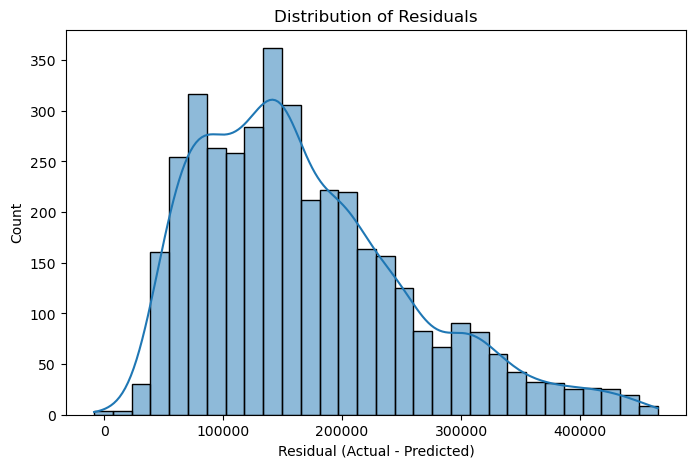

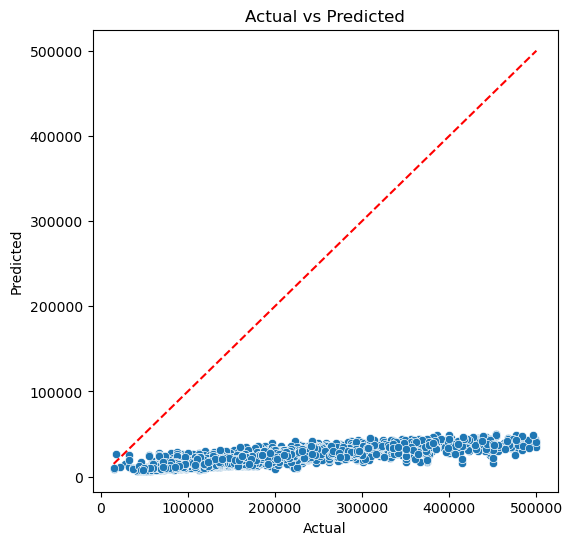

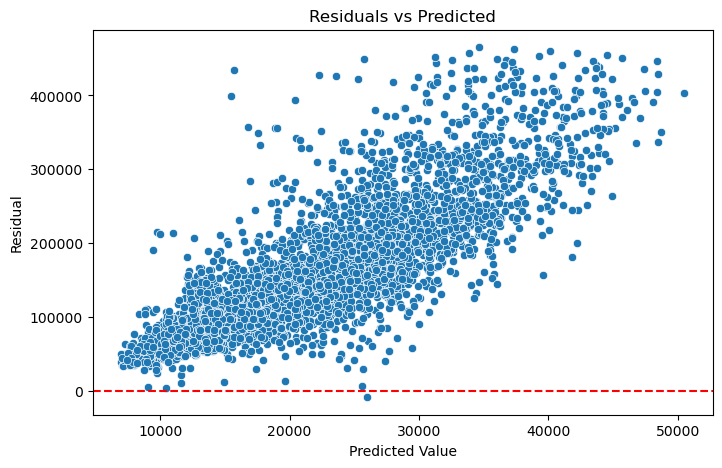

Top 10 worst predictions:
         Actual     Predicted       Residual  Absolute Residual  Percent Error
14405  500000.0  34673.148438  465326.851562      465326.851562       0.930654
15979  500000.0  37321.441406  462678.558594      462678.558594       0.925357
8933   500000.0  40122.546875  459877.453125      459877.453125       0.919755
15682  500000.0  42192.648438  457807.351562      457807.351562       0.915615
6205   491200.0  33856.199219  457343.800781      457343.800781       0.931075
4237   498700.0  44521.128906  454178.871094      454178.871094       0.910726
8991   492500.0  39305.046875  453194.953125      453194.953125       0.920193
140    483300.0  31221.185547  452078.814453      452078.814453       0.935400
17048  495900.0  45662.339844  450237.660156      450237.660156       0.907920
15747  475000.0  25720.146484  449279.853516      449279.853516       0.945852


In [164]:

# y_test: ground truth, y_pred: model prediction
residuals = y_test - y_pred
abs_residuals = np.abs(residuals)
percent_error = abs_residuals / np.abs(y_test)

error_df = pd.DataFrame({
    "Actual": y_test,
    "Predicted": y_pred,
    "Residual": residuals,
    "Absolute Residual": abs_residuals,
    "Percent Error": percent_error
})

# 1. Residual Distribution
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Distribution of Residuals")
plt.xlabel("Residual (Actual - Predicted)")
plt.show()

# 2. Predicted vs Actual
plt.figure(figsize=(6, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()

# 3. Residual vs Predicted (look for heteroscedasticity)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs Predicted")
plt.xlabel("Predicted Value")
plt.ylabel("Residual")
plt.show()

# 4. Identify worst predictions
worst_cases = error_df.sort_values(by="Absolute Residual", ascending=False).head(10)
print("Top 10 worst predictions:")
print(worst_cases)


In [165]:
# These are true outliers that might not follow the pattern the model has learned.
X_test.loc[5887, :]

longitude               -118.33
latitude                  34.15
housing_median_age         39.0
total_rooms               493.0
total_bedrooms            168.0
population                259.0
households                138.0
median_income            2.3667
ocean_proximity       <1H OCEAN
rooms_per_house        3.572464
bedrooms_ratio         0.340771
people_per_house       1.876812
Name: 5887, dtype: object

In [166]:
# Explain the model's predictions using SHAP
explainer = shap.Explainer(final_model)
shap_values = explainer(test_dmatrix)

shap.summary_plot(shap_values, X_test)


TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: <xgboost.core.Booster object at 0x32fc8d110>

In [ ]:
# compute a 95% confidence interval for the generalization error using scipy.stats.bootstrap().
# Defines a helper function to compute RMSE from squared errors.
def rmse_func(squared_errors):
    return np.sqrt(np.mean(squared_errors))

confidence = 0.95
squared_errors = (y_pred - y_test) ** 2
# It performs bootstrap resampling on the squared_errors data (i.e., repeatedly samples with replacement).
# Each resample is used to compute an RMSE via rmse_func function.
boot_result = stats.bootstrap([squared_errors], rmse_func,
                              confidence_level=confidence, random_state=42)
# After many iterations (by default, 9999), it calculates the confidence interval of the RMSE distribution.
rmse_lower, rmse_upper = boot_result.confidence_interval

print(f"95% CI for RMSE: [{rmse_lower:.4f}, {rmse_upper:.4f}]")


95% CI for RMSE: [46776.2654, 50336.1104]


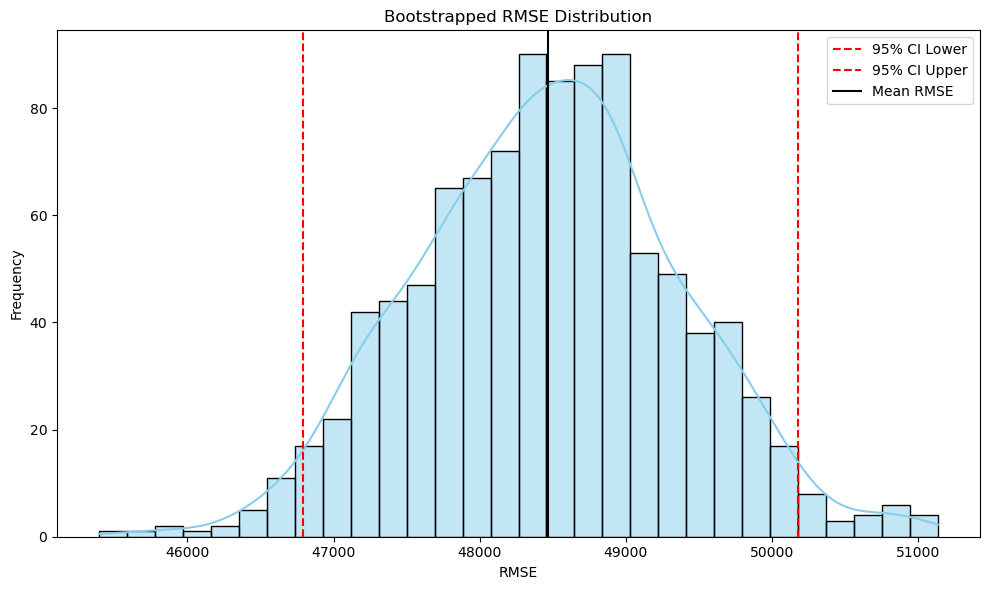

In [ ]:
n_iterations = 1000

rng = np.random.default_rng(seed=42)

rmse_samples = []

n = len(squared_errors)
for _ in range(n_iterations):
    # Sample with replacement
    sample = rng.choice(squared_errors, size=n, replace=True)
    rmse_sample = rmse_func(sample)
    rmse_samples.append(rmse_sample)

# Compute confidence interval
lower_bound = np.percentile(rmse_samples, (1 - confidence) / 2 * 100)
upper_bound = np.percentile(rmse_samples, (1 + confidence) / 2 * 100)

# 📈 Plotting the RMSE distribution
plt.figure(figsize=(10, 6))
sns.histplot(rmse_samples, bins=30, kde=True, color="skyblue")
plt.axvline(lower_bound, color="red", linestyle="--", label=f"{int(confidence*100)}% CI Lower")
plt.axvline(upper_bound, color="red", linestyle="--", label=f"{int(confidence*100)}% CI Upper")
plt.axvline(np.mean(rmse_samples), color="black", linestyle="-", label="Mean RMSE")
plt.title("Bootstrapped RMSE Distribution")
plt.xlabel("RMSE")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()
